# Twitter Bot Detection com BERT (Keras)

**Objetivo:** treinar um modelo baseado em BERT (Hugging Face Transformers + TensorFlow/Keras) para classificar contas/tweets como **bot** ou **humano** usando o dataset **Twitter-Bot Detection** (Kaggle).



In [3]:
import sys, platform, tensorflow as tf
print("Python:", sys.version)
print("TensorFlow:", tf.__version__)
print("CUDA available (tf):", tf.test.is_built_with_cuda(), " | GPUs:", tf.config.list_physical_devices('GPU'))

Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
TensorFlow: 2.19.0
CUDA available (tf): True  | GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1) Preparação do ambiente

- Instalar dependências: `transformers`, `datasets`, `evaluate`, `scikit-learn`, `matplotlib`, `pandas`, `tensorflow-addons`
- Configurar diretórios de trabalho e uma seed global para reprodutibilidade.


In [4]:
!pip -q install -U datasets evaluate matplotlib kaggle scikit-learn transformers==4.28.1 tensorflow==2.12.0

import os, random, numpy as np
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 113.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 19.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 100.4 MB/s eta 0:00:0

OK: ambiente preparado.


### 2) Carga e Inspeção do Dataset

- Carregar o CSV em um DataFrame pandas.
- Identificar automaticamente as colunas de texto e rótulo (bot/humano).
- Exibir informações básicas do dataset (`.info()`, `.head()`, `.value_counts()`).

In [12]:
import pandas as pd

TEXT_COL = 'Tweet'
LABEL_COL = 'Bot Label'

try:
    df = pd.read_csv(os.path.join(DATA_DIR, "bot_detection_data.csv"))

    if TEXT_COL not in df.columns or LABEL_COL not in df.columns:
         raise ValueError(f"Colunas de texto ('{TEXT_COL}') ou rótulo ('{LABEL_COL}') não encontradas no dataset. Por favor, ajuste manualmente.")

    print(f"Coluna de texto usada: '{TEXT_COL}'")
    print(f"Coluna de rótulo usada: '{LABEL_COL}'")

    print("\nInformações do dataset:")
    df.info()

    print("\nPrimeiras linhas do dataset:")
    display(df.head())

    print("\nDistribuição dos rótulos:")
    display(df[LABEL_COL].value_counts())

except FileNotFoundError:
    print(f"Erro: O arquivo CSV não foi encontrado em {DATA_DIR}. Verifique se o nome do arquivo e o caminho estão corretos.")
except Exception as e:
    print(f"Ocorreu um erro ao carregar ou inspecionar o dataset: {e}")

Coluna de texto detectada: 'Tweet'
Coluna de rótulo detectada: 'Bot Label'

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28139 entries, 0 to 28138
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   User ID         28139 non-null  int64  
 1   Username        28139 non-null  object 
 2   Tweet           28138 non-null  object 
 3   Retweet Count   28138 non-null  float64
 4   Mention Count   28138 non-null  float64
 5   Follower Count  28138 non-null  float64
 6   Verified        28138 non-null  object 
 7   Bot Label       28138 non-null  float64
 8   Location        28138 non-null  object 
 9   Created At      28138 non-null  object 
 10  Hashtags        23411 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 2.4+ MB

Primeiras linhas do dataset:


,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags
0,132131,flong,Station activity person against natural majori...,85.0,1.0,2353.0,False,1.0,Adkinston,2020-05-11 15:29:50,NaN
1,289683,hinesstephanie,Authority research natural life material staff...,55.0,5.0,9617.0,True,0.0,Sanderston,2022-11-26 05:18:10,both live
2,779715,roberttran,Manage whose quickly especially foot none to g...,6.0,2.0,4363.0,True,0.0,Harrisonfurt,2022-08-08 03:16:54,phone ahead
3,696168,pmason,Just cover eight opportunity strong policy which.,54.0,5.0,2242.0,True,1.0,Martinezberg,2021-08-14 22:27:05,ever quickly new I
4,704441,noah87,Animal sign six data good or.,26.0,3.0,8438.0,False,1.0,Camachoville,2020-04-13 21:24:21,foreign mention



Distribuição dos rótulos:


,count
Bot Label,
1.0,14092
0.0,14046


In [13]:
from google.colab import files
import os, zipfile, glob, shutil, json, pathlib, sys

DATA_DIR = "/content/data"
os.makedirs(DATA_DIR, exist_ok=True)

!cp "/content/bot_detection_data.csv" "{DATA_DIR}/bot_detection_data.csv"


print("Arquivos disponíveis em /content/data:")
print(os.listdir(DATA_DIR))

Arquivos disponíveis em /content/data:
['bot_detection_data.csv']


## 3) Inspeção & mapeamento de colunas

Como diferentes versões do dataset variam, tentaremos:
- Encontrar **coluna de texto** entre: `["text","tweet","tweet_text","description","bio","profile_description","content"]`
- Encontrar **coluna de rótulo** entre: `["label","is_bot","bot","account_type","target"]` (mapeando para {0: humano, 1: bot})

Se nada for encontrado, a célula lança erro com instruções de ajuste manual.

In [14]:
import pandas as pd
import os
import glob
import numpy as np


csvs = [p for p in glob.glob(f"{DATA_DIR}/**/*.csv", recursive=True)]
if not csvs:
    raise FileNotFoundError("Nenhum CSV encontrado. Verifique os arquivos extraídos em /content/data.")

csv_sizes = [(p, os.path.getsize(p)) for p in csvs]
csv_main = sorted(csv_sizes, key=lambda x: x[1], reverse=True)[0][0]
print("CSV principal detectado:", csv_main)

df = pd.read_csv(csv_main, low_memory=False)
print("Shape:", df.shape)
print("Colunas:", list(df.columns)[:50])


text_col = 'Tweet'
label_col = 'Bot Label'

if text_col is None or label_col is None:
     raise ValueError("As colunas de texto e rótulo devem ser definidas manualmente.")


print("Coluna de texto:", text_col)
print("Coluna de rótulo:", label_col)

label_map = {
    "bot": 1, "human": 0, "Bot": 1, "Human": 0,
    "BOT": 1, "HUMAN": 0, "spam": 1, "genuine": 0
}

def normalize_label(x):
    if pd.isna(x): return np.nan
    if isinstance(x, str):
        x = x.strip()
        if x.isdigit(): return int(x)
        return label_map.get(x, np.nan)
    if x in [0,1]: return int(x)
    return np.nan

df["_label"] = df[label_col].apply(normalize_label)

if df["_label"].isna().mean() > 0.5:
    try:
        df["_label"] = pd.to_numeric(df[label_col], errors="coerce")
    except:
        pass


before = len(df)
df = df.dropna(subset=[text_col, "_label"])
df["_label"] = df["_label"].astype(int)
after = len(df)
print(f"Linhas removidas por NaN/inválidos: {before-after}")

df = df[[text_col, "_label"]].rename(columns={text_col: "text", "_label": "label"})
display(df.head(3))

CSV principal detectado: /content/data/bot_detection_data.csv
Shape: (50000, 11)
Colunas: ['User ID', 'Username', 'Tweet', 'Retweet Count', 'Mention Count', 'Follower Count', 'Verified', 'Bot Label', 'Location', 'Created At', 'Hashtags']
Coluna de texto: Tweet
Coluna de rótulo: Bot Label
Linhas removidas por NaN/inválidos: 0


,text,label
0,Station activity person against natural majori...,1
1,Authority research natural life material staff...,0
2,Manage whose quickly especially foot none to g...,0


## 4) EDA rápida

- Tamanho do dataset após limpeza
- Distribuição de classes (balanceamento)
- Comprimento dos textos


Total de linhas: 50000
label
1    25018
0    24982
Name: count, dtype: int64
count    50000.000000
mean         9.571200
std          2.329463
min          6.000000
25%          8.000000
50%         10.000000
75%         12.000000
max         14.000000
Name: len, dtype: float64


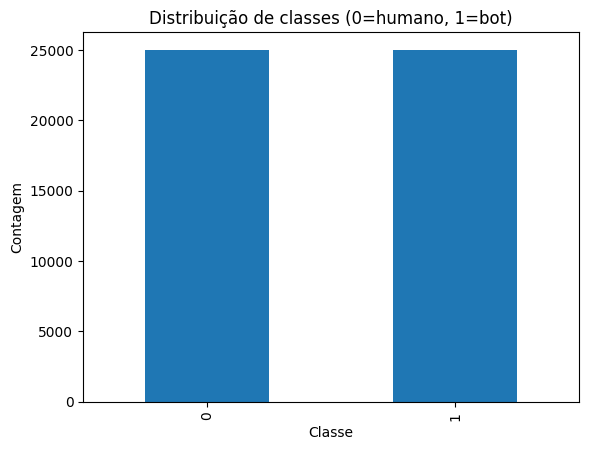

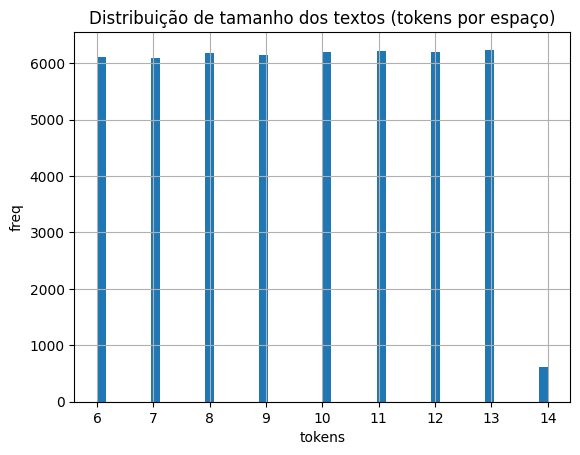

In [15]:
import matplotlib.pyplot as plt
import numpy as np

print("Total de linhas:", len(df))
print("Distribuição de classes (0=humano, 1=bot):")
print(df["label"].value_counts())

df["len"] = df["text"].astype(str).apply(lambda s: len(s.split()))
print("\nEstatísticas de comprimento dos textos:")
print(df["len"].describe())

vc = df["label"].value_counts().sort_index()
plt.figure()
vc.plot(kind="bar")
plt.title("Distribuição de classes (0=humano, 1=bot)")
plt.xlabel("Classe"); plt.ylabel("Contagem")
plt.xticks(ticks=[0, 1], labels=["Humano (0)", "Bot (1)"], rotation=0)
plt.show()

plt.figure()
df["len"].hist(bins=50)
plt.title("Distribuição de tamanho dos textos (tokens por espaço)")
plt.xlabel("Número de tokens (aprox)"); plt.ylabel("Frequência")
plt.show()

## 5) Split estratificado + Tokenizer BERT

- Split (train/val/test) estratificado (80/10/10)
- Tokenização com `bert-base-uncased` (pode trocar por outro modelo se preferir)
- `max_length=128` com truncamento/padding


In [16]:
import numpy as np

def stratified_split(df, stratify_col, test_size=0.2, val_size=0.5, seed=42):
    np.random.seed(seed)
    idx_train, idx_temp = [], []
    for label in df[stratify_col].unique():
        idx = df[df[stratify_col]==label].index.values
        np.random.shuffle(idx)
        cut = int(len(idx)*(1-test_size))
        idx_train.extend(idx[:cut])
        idx_temp.extend(idx[cut:])
    train_df = df.loc[idx_train]
    temp_df = df.loc[idx_temp]

    idx_val, idx_test = [], []
    for label in temp_df[stratify_col].unique():
        idx = temp_df[temp_df[stratify_col]==label].index.values
        np.random.shuffle(idx)
        cut = int(len(idx)*(1-val_size))
        idx_val.extend(idx[:cut])
        idx_test.extend(idx[cut:])
    val_df = temp_df.loc[idx_val]
    test_df = temp_df.loc[idx_test]

    return train_df, val_df, test_df

train_df, val_df, test_df = stratified_split(df, stratify_col="label", test_size=0.2, val_size=0.5, seed=SEED)
print("train/val/test:", len(train_df), len(val_df), len(test_df))

train/val/test: 39999 5000 5001


## 6) Preparar tf.data.Dataset

- Criar datasets do TensorFlow (`train_ds`, `val_ds`, `test_ds`) a partir dos dados tokenizados.
- Configurar lotes, shuffle (para treino) e prefetch para otimizar o pipeline.

In [17]:
from transformers import AutoTokenizer
import tensorflow as tf

MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 128

def tokenize_batch(texts):
    return tokenizer(
        list(texts),
        max_length=MAX_LEN,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )

BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## 7) Modelo BERT + Keras

- Backbone: `TFBertModel` (`bert-base-uncased`) com pesos nativos TensorFlow.
- Construção do modelo usando Keras Functional API com inputs (`input_ids`, `attention_mask`).
- Camada `Dropout` + `Dense(1, activation='sigmoid')` para classificação binária na saída do token `[CLS]`.
- **Class weights** (opcional) se houver desbalanceamento.
- Otimizador Adam com `learning_rate` definido.
- Métrica F1 binária customizada.

In [35]:
from transformers import TFBertModel
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf

backbone = TFBertModel.from_pretrained(MODEL_NAME, from_pt=False)

input_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')

outputs = backbone(input_ids=input_ids, attention_mask=attention_mask)
seq_output = outputs.last_hidden_state

cls_token = tf.keras.layers.Lambda(lambda x: x[:, 0, :], name="cls_slice")(seq_output)

x = tf.keras.layers.Dropout(0.2)(cls_token)
logits = tf.keras.layers.Dense(1, activation='sigmoid', name="classifier_output")(x)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=logits)
model.summary()

def f1_m(y_true, y_pred, threshold=0.5):
    y_pred_ = tf.cast(y_pred >= threshold, tf.int32)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred_, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred_, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred_), tf.float32))
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    return 2 * precision * recall / (precision + recall + 1e-8)

LR = 2e-5
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc"),
             tf.keras.metrics.AUC(name="auc"),
             f1_m]
)

class_weights = None
if 'train_df' in locals() and 'label' in train_df.columns:
    counts = train_df["label"].value_counts()
    ratio = counts.max() / counts.min()
    print("Class balance ratio (max/min):", ratio)
    if ratio > 1.5:
        classes = np.array([0, 1])
        weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df["label"].values)
        class_weights = {0: float(weights[0]), 1: float(weights[1])}
        print("Usando class_weights:", class_weights)
    else:
        print("Classes razoavelmente balanceadas. Sem class_weights.")
else:
    print("train_df or 'label' column not found. Cannot compute class weights.")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_last_hidden    │ (None, 128, 768)  │          0 │ input_ids[0][0],  │
│ (Lambda)            │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls_slice (Lambda)  │ (None, 768)       │          0 │ bert_last_hidden… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 768)       │          0 │ cls_slice[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        769 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

Class balance ratio (max/min): 1.001451088316237
Classes razoavelmente balanceadas. Sem class_weights.


In [36]:
import tensorflow as tf

def to_dataset(df_):
    enc = tokenize_batch(df_["text"])
    y = tf.convert_to_tensor(df_["label"].values, dtype=tf.int32)
    ds = tf.data.Dataset.from_tensor_slices(({'input_ids': enc['input_ids'], 'attention_mask': enc['attention_mask']}, y))
    return ds

train_ds = to_dataset(train_df).shuffle(2048, seed=SEED).batch(BATCH_SIZE).prefetch(AUTO)
val_ds   = to_dataset(val_df).batch(BATCH_SIZE).prefetch(AUTO)
test_ds  = to_dataset(test_df).batch(BATCH_SIZE).prefetch(AUTO)

print("OK: tf.data.Datasets preparados.")

OK: tf.data.Datasets preparados.


## 8) Treinamento

- `EarlyStopping` em `val_auc`
- `ModelCheckpoint` para salvar o melhor modelo
- Número de épocas moderado (3–5) — BERT converge rápido para fine-tuning


In [21]:
import tensorflow as tf
import os

ckpt_dir = f"{ART_DIR}/checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=2, mode="max", restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, "bert_botdet_best.keras"),
        monitor="val_auc",
        mode="max",
        save_best_only=True
    )
]

EPOCHS = 4

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/4
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 327s 246ms/step - acc: 0.8263 - auc: 0.3245 - f1_m: 0.8215 - loss: 0.4834 - val_acc: 0.4984 - val_auc: 0.4927 - val_f1_m: 0.0000e+00 - val_loss: 0.8687
Epoch 2/4
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 294s 235ms/step - acc: 0.4307 - auc: 0.2283 - f1_m: 0.4455 - loss: 0.8564 - val_acc: 0.4994 - val_auc: 0.4925 - val_f1_m: 0.0000e+00 - val_loss: 0.8866
Epoch 3/4
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 294s 235ms/step - acc: 0.4111 - auc: 0.2216 - f1_m: 0.4220 - loss: 0.8841 - val_acc: 0.4996 - val_auc: 0.4915 - val_f1_m: 0.0000e+00 - val_loss: 0.8836


**O que observar:**
- `val_auc` crescendo e estabilizando: bom sinal de generalização.
- `acc` e `f1_m` ajudam a ver equilíbrio entre precisão/recall.  
Se `val_auc` cair/saturar cedo, reduzir `EPOCHS` ou aumentar `Dropout`. Se `overfitting`, experimente `MAX_LEN` menor (ex.: 96) ou `learning rate` mais baixo.


## 9) Avaliação no conjunto de teste

- Métricas: Accuracy, F1, Precision, Recall, AUC
- Matriz de confusão
- Curvas ROC e Precision-Recall


157/157 ━━━━━━━━━━━━━━━━━━━━ 50s 275ms/step
Accuracy: 0.5003 | Precision: 1.0000 | Recall: 0.0012 | F1: 0.0024
Matriz de confusão [[TN, FP],[FN, TP]] =
[[2499    0]
 [2499    3]]
AUC-ROC: 0.4944


/tmp/ipython-input-1741930126.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_roc = np.trapz(tpr, fpr)


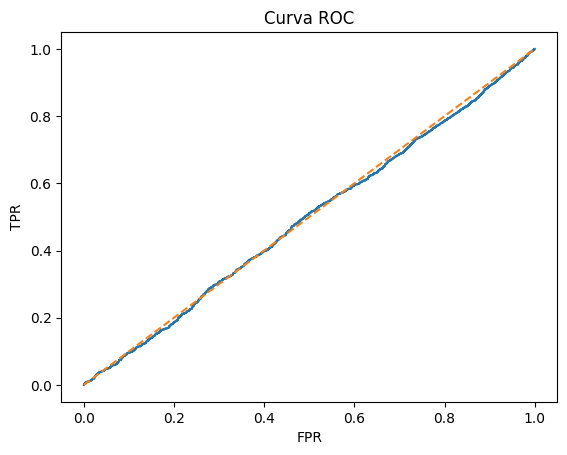

Average Precision (aprox.): 0.4977


/tmp/ipython-input-1741930126.py:66: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ap = np.trapz(prec_pr, rec_pr)


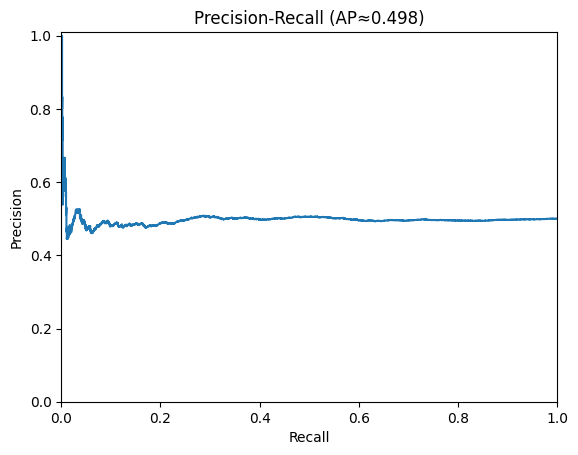

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, average_precision_score

y_true = test_df["label"].values.astype(int)
y_prob = model.predict(test_ds).ravel().astype(float)
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
acc = np.sum(y_true == y_pred) / len(y_true)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1] + 1e-12)
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0] + 1e-12)
f1 = 2 * precision * recall / (precision + recall + 1e-12)

print(f"Accuracy: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
print("Matriz de confusão [[TN, FP],[FN, TP]] =")
print(cm)

auc_roc = roc_auc_score(y_true, y_prob)
print(f"AUC-ROC: {auc_roc:.4f}")

fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.title("Curva ROC")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

precision_pr, recall_pr, _ = precision_recall_curve(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)
print(f"Average Precision (AP): {ap:.4f}")

plt.figure()
plt.plot(recall_pr, precision_pr)
plt.title(f"Precision-Recall (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.ylim(0,1.01); plt.xlim(0,1.0)
plt.show()

## 10) Salvar modelo/tokenizer e artefatos

- Salva modelo Keras (`.keras`) e SavedModel
- Salva tokenizer `save_pretrained`
- Exporta métricas para JSON


In [37]:
import json
import os
import numpy as np
import tensorflow as tf

SAVE_DIR = f"{ART_DIR}/model"
TOK_DIR  = f"{ART_DIR}/tokenizer"
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(TOK_DIR, exist_ok=True)

model_path = f"{SAVE_DIR}/bert_botdet_best.keras"
model.save(model_path)
print("Modelo salvo em:", model_path)

tokenizer.save_pretrained(TOK_DIR)
print("Tokenizer salvo em:", TOK_DIR)

metrics = {
    "test_auc": "N/A - Evaluation failed",
    "classification_report": "N/A - Evaluation failed",
    "confusion_matrix": "N/A - Evaluation failed"
}
if 'acc' in locals() and 'precision' in locals() and 'recall' in locals() and 'f1' in locals() and 'auc_roc' in locals() and 'ap' in locals() and 'cm' in locals():
     metrics = {
        "accuracy": float(acc),
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "auc_roc": float(auc_roc),
        "average_precision": float(ap),
        "confusion_matrix": cm.tolist()
    }


with open(f"{ART_DIR}/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)
print("Métricas salvas em:", f"{ART_DIR}/metrics.json")

Modelo salvo em: /content/artifacts/model/bert_botdet_best.keras
Tokenizer salvo em: /content/artifacts/tokenizer
Métricas salvas em: /content/artifacts/metrics.json


## 11) Inferência: função `predict_bot(text)`

- Carrega modelo/tokenizer dos diretórios salvos
- Recebe texto (tweet/bio) e retorna probabilidade de **bot**


In [40]:
from transformers import AutoTokenizer
import tensorflow as tf
import numpy as np, json, os

SAVE_DIR = f"{ART_DIR}/model"
TOK_DIR = f"{ART_DIR}/tokenizer"
model_path = f"{SAVE_DIR}/bert_botdet_best.keras"

loaded_model = tf.keras.models.load_model(model_path, custom_objects={"f1_m": f1_m})
loaded_tokenizer = AutoTokenizer.from_pretrained(TOK_DIR)

def predict_bot(texts, max_len=128, threshold=0.5):
    if isinstance(texts, str):
        texts = [texts]
    enc = loaded_tokenizer(
        texts,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )
    probs = loaded_model.predict({"input_ids": enc["input_ids"], "attention_mask": enc["attention_mask"]}).ravel()
    preds = (probs >= threshold).astype(int)
    return probs, preds

probs, preds = predict_bot(["Free iPhone!!! Click here http://spam", "Olá! Sou um estudante de engenharia e adoro nadar."])
list(zip(probs, preds))

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


[(np.float32(0.54856324), np.int64(1)), (np.float32(0.49103677), np.int64(0))]